# Neural network

In this project, we will train a neural network to draw a curve.
The curve takes one input variable, the amount travelled along the curve from 0 to 1, and returns 2 outputs, the 2D coordinates of the position of points on the curve.

To help capture the complexity of the curve, we shall use a deep neural network.

![Neural network with 2 hidden layers. There is 1 nodes in the zeroth layer, 6 in the first, 7 in the second, and 2 in the third.](readonly/bigNet.png "The structure of the network we will consider in this assignment.")


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


## Dataset initialization and plotting functions

In [2]:
def training_data(N=100):
    """Create N training examples.
    
    This curve takes one input variable, the amount travelled along the curve from 0 to 1, and 
    returns 2 outputs, the 2D coordinates of the position of points on the curve.
    """
    x = np.arange(0, 1, 1 / N)
    y = np.array([16 * np.sin(2 * np.pi * x)**3,
      13 * np.cos(2 * np.pi * x) - 5 * np.cos(2 * 2 * np.pi * x) - 2 * np.cos(3 * 2 * np.pi * x) - np.cos(4 * 2 * np.pi * x)
                 ]) / 40 + 0.5
    
    x = np.reshape(x, (1, N))
    return x, y


In [3]:
def train_data(N=100):
    """Plot N training examples."""
    _, y = training_data(N)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    ax.set_aspect(1)
    ax.scatter(y[0], y[1], s=10, marker='o')
    plt.show()
    

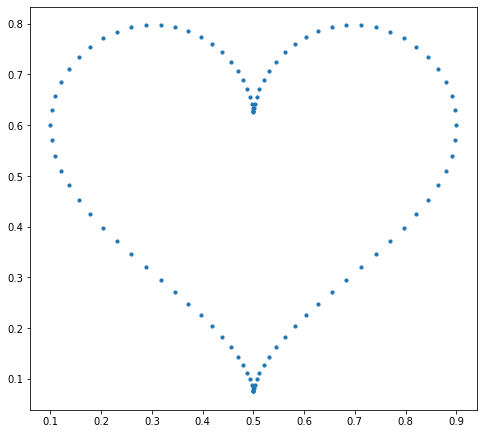

In [4]:
train_data()

### Color map for training visualization

In [5]:
magenta = (0xfc/255, 0x75/255, 0xdb/255) # Brighter magenta
magentaTrans = (0xfc/255, 0x75/255, 0xdb/255, 0.1) # Brighter Transparent magenta
orange = (218/255, 171/255, 115/255)
green = (175/255, 219/255, 133/255)
white = (240/255, 245/255, 250/255)
blue1 = (70/255, 101/255, 137/255)
blue2 = (122/255, 174/255, 215/255)


def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


blueMap = make_colormap([blue2, blue1])

## Network initialization function

In [6]:
def initialize_network(x, layer_sizes, seed=100):
    """Initialize the network with it's structure.
    
    Note: Any training already done is reset.
    """
    global weights, biases
    
    weights = []
    biases = []
    generator = np.random.default_rng(seed)
    
    previous_layer_size = x.shape[0]
    for layer_size in layer_sizes:
        # weights are intialized using Xavier initialization
        weights.append(generator.standard_normal((layer_size, previous_layer_size)) * np.sqrt(1 / previous_layer_size))
    
        # biases are intialized to 0
        biases.append(np.zeros((layer_size, 1)))
        
        previous_layer_size = layer_size
        

## Activation function

In [7]:
def sigmoid(z): 
    """The sigmoid activation function."""
    return 1 / (1 + np.exp(-z))


def d_sigmoid(z):
    """The derivative of the sigmoid."""
    return sigmoid(z) * (1 - sigmoid(z))


## Feed forward

Next we will define functions to set up our neural network.
Namely an activation function, $\sigma(z)$, it's derivative, $\sigma'(z)$, a function to initialise weights and biases, and a function that calculates each activation of the network using feed-forward.

Recall the feed-forward equations,
$$ \mathbf{a}^{(n)} = \sigma(\mathbf{z}^{(n)}) $$
$$ \mathbf{z}^{(n)} = \mathbf{W}^{(n)}\mathbf{a}^{(n-1)} + \mathbf{b}^{(n)} $$

We will use the *logistic function* as our activation function, rather than $\tanh$.
$$ \sigma(\mathbf{z}) = \frac{1}{1 + \exp(-\mathbf{z})} $$


In [8]:
def feed_forward(x):
    """Feed forward each activation to the next layer and return all weighted sums and activations.
    """
    activations = []
    z_terms = []
    num_layers = len(weights)
    
    previous_activation = x
    for layer in range(num_layers):
        z = weights[layer] @ previous_activation + biases[layer]
        activation = sigmoid(z)
        z_terms.append(z)
        activations.append(activation)
        previous_activation = activation
    
    return activations, z_terms


## Cost function 

In [9]:
def cost(predictions, y, reg_param):
    """The cost is defined as the sum of the squared errors devided by the number of training examples, plus
    an L2 regularization term.
    """
    n = y.shape[1]
    term1 = ((predictions - y)**2).sum() / n
    
    w2 = 0
    for w in weights:
        w2 += (w**2).sum()
    term2 = (reg_param / (2 * n)) * w2
    
    return term1 + term2


## Backpropagation

Next we will define the partial derivatives of the cost function with respect to the weights and biases.

### Layer 3

We'll define our Jacobians as,
$$ \mathbf{J}_{\mathbf{W}^{(3)}} = \frac{\partial C}{\partial \mathbf{W}^{(3)}} $$
$$ \mathbf{J}_{\mathbf{b}^{(3)}} = \frac{\partial C}{\partial \mathbf{b}^{(3)}} $$
etc., where $C$ is the average cost function over the training set. i.e.,
$$ C = \frac{1}{N}\sum_k C_k $$  

The partial derivatives take the form:
$$ \frac{\partial C}{\partial \mathbf{W}^{(3)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{W}^{(3)}}
   $$
for the weight, and similarly for the bias,
$$ \frac{\partial C}{\partial \mathbf{b}^{(3)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{b}^{(3)}}
   $$  

$$ \frac{\partial C}{\partial \mathbf{a}^{(3)}} = 2(\mathbf{a}^{(3)} - \mathbf{y}) $$
$$ \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}} = \sigma'({z}^{(3)})$$
$$ \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{W}^{(3)}} = \mathbf{a}^{(2)}$$
$$ \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{b}^{(3)}} = 1$$

### Layer 2

The partial derivatives are:  

$$ \frac{\partial C}{\partial \mathbf{W}^{(2)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \right)
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{z}^{(2)}}
   \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{W}^{(2)}}
   $$
$$ \frac{\partial C}{\partial \mathbf{b}^{(2)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \right)
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{z}^{(2)}}
   \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{b}^{(2)}}
   $$
   
This is very similar to the previous layer, with two exceptions:
* There is a new partial derivative, in parentheses, $\frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}$
* The terms after the parentheses are now one layer lower.  

The new partial derivative takes the form:  

$$ \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}} =
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{z}^{(3)}}
   \frac{\partial \mathbf{z}^{(3)}}{\partial \mathbf{a}^{(2)}} =
   \sigma'(\mathbf{z}^{(3)})
   \mathbf{W}^{(3)}
$$


### Layer 1

Layer 1 is similar to Layer 2, but with an additional partial derivative term.  

$$ \frac{\partial C}{\partial \mathbf{W}^{(1)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{a}^{(1)}}
   \right)
   \frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}
   \frac{\partial \mathbf{z}^{(1)}}{\partial \mathbf{W}^{(1)}}
   $$  
   

$$ \frac{\partial C}{\partial \mathbf{b}^{(1)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(3)}}
   \left(
   \frac{\partial \mathbf{a}^{(3)}}{\partial \mathbf{a}^{(2)}}
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{a}^{(1)}}
   \right)
   \frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}
   \frac{\partial \mathbf{z}^{(1)}}{\partial \mathbf{b}^{(1)}}
   $$


In [10]:
def back_propagate(x, y, activations, z_terms, reg_param):
    """Calculate and return the partial derivatives for each layer."""

    d_weights = []
    d_biases = []
    n = y.shape[1]
    
    # partial derivatives for the last layer
    layer = len(weights) - 1
    da = (2 / x.shape[1]) * (activations[layer] - y)
    dz = da * d_sigmoid(z_terms[layer])
    dw = dz @ activations[layer - 1].T + (reg_param / n) * weights[layer]
    db = np.sum(dz, axis=1, keepdims=True)    
    d_weights.append(dw)
    d_biases.append(db)

    layer -= 1
    while layer >= 1:
        da = weights[layer + 1].T @ dz
        dz = da * d_sigmoid(z_terms[layer])
        dw = dz @ activations[layer - 1].T + (reg_param / n) * weights[layer]
        db = np.sum(dz, axis=1, keepdims=True)
        d_weights.append(dw)
        d_biases.append(db)
        layer -= 1
        
    # partial derivatives for the first layer
    da = weights[layer + 1].T @ dz
    dz = da * d_sigmoid(z_terms[layer])
    dw = dz @ x.T + (reg_param / n) * weights[layer]
    db = np.sum(dz, axis=1, keepdims=True)
    d_weights.append(dw)
    d_biases.append(db)
        
    return d_weights[:: -1], d_biases[:: -1]


## Training function 

In [27]:
def train(x, y, iterations=10000, aggression=1, noise=0, plot_interval=2500, reg_param=0.0):
    """Train the neural network and plot the progress and final result."""
    
    global weights, biases
    
    ax1, ax2 = initialize_plot(x, y, reg_param)
    generator = np.random.default_rng()
    
    # train the network
    num_layers = len(weights)
    for iteration in range(iterations):
        activations, z_terms = feed_forward(x)
        d_weights, d_biases = back_propagate(x, y, activations, z_terms, reg_param)
        
        if noise != 0:
            for dw in d_weights:
                dw = dw * (1 + generator.standard_normal() * noise)
      
        for layer in range(num_layers):
            weights[layer] = weights[layer] - aggression * d_weights[layer]
            biases[layer] = biases[layer] - aggression * d_biases[layer]
        
        # plot intermediate results
        if (iteration % plot_interval == 0):
            points = activations[-1]
            ax1.plot(points[0], points[1], lw=2, color=magentaTrans);
            ax2.scatter(iteration, cost(points, y, reg_param), color='blue', s=8)

    # plot the final result
    activations, z_terms = feed_forward(x) 
    points = activations[-1]
    ax1.plot(points[0], points[1], lw=2.5, color=orange);
    final_cost = cost(points, y, reg_param)
    ax2.scatter(iteration, final_cost, color='blue', s=8, label="Final cost: {:.3e}".format(final_cost))
    ax2.legend(loc='upper center')
    

In [12]:
def initialize_plot(x, y, reg_param):
    fig = plt.figure(figsize=(20, 10), dpi=80)
    
    ax1, ax2 = fig.subplots(1, 2)
    ax1.set_title('Training results')
    ax2.set_title('Cost function')
    
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_aspect(1)
    
    ax2.set_yscale('log')

    # plot the background
    xx = np.arange(0, 1.01, 0.01)
    yy = np.arange(0, 1.01, 0.01)
    X, Y = np.meshgrid(xx, yy)
    Z = ((X-0.5)**2 + (Y-1)**2)**(1/2) / (1.25)**(1/2)
    ax1.imshow(Z, vmin=0, vmax=1, extent=[0, 1, 1, 0], cmap=blueMap)

    # plot the training points
    ax1.scatter(y[0], y[1], color=green, s=10);
    
    # plot the initial cost
    activations, z_terms = feed_forward(x)
    points = activations[-1]
    ax2.scatter(0, cost(points, y, reg_param), color='blue', s=8)
    return ax1, ax2
    

## Training

#### First, we generate the training data.

In [13]:
x, y = training_data(100)

### Next we initialize and train a network of 50 neurons arranged in various layers

### One hidden layer

In [16]:
initialize_network(x, [50, 2])

Wall time: 27.7 s


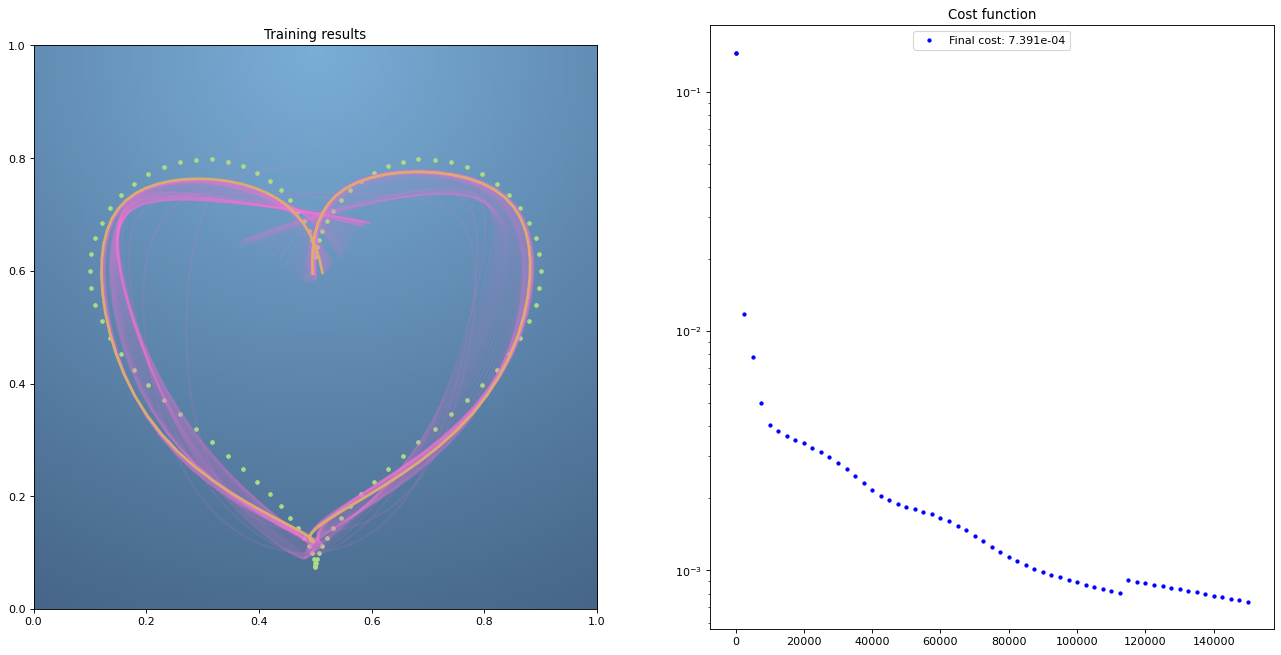

In [17]:
%time train(x, y, iterations=150000, aggression=3, reg_param=0.0)

### Two hidden layers

In [18]:
initialize_network(x, [25, 25, 2])

Wall time: 34.8 s


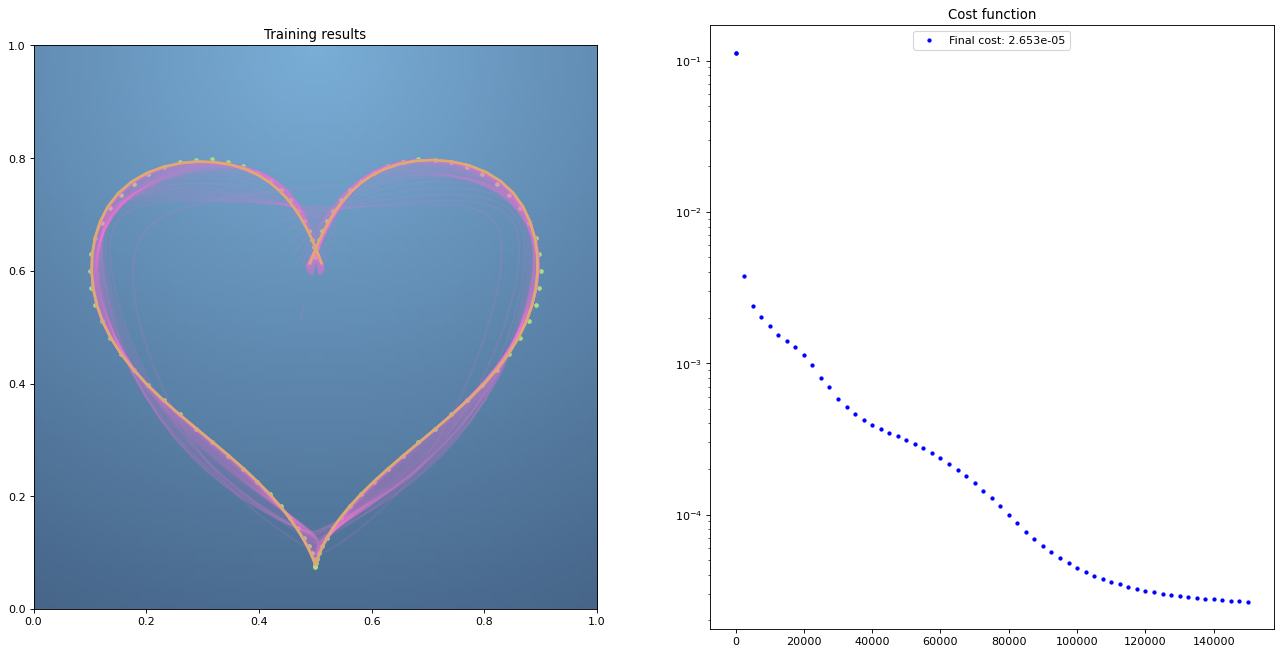

In [19]:
%time train(x, y, iterations=150000, aggression=3, reg_param=0.0)

### Three hidden layers

In [20]:
initialize_network(x, [16, 18, 16, 2])

Wall time: 38.3 s


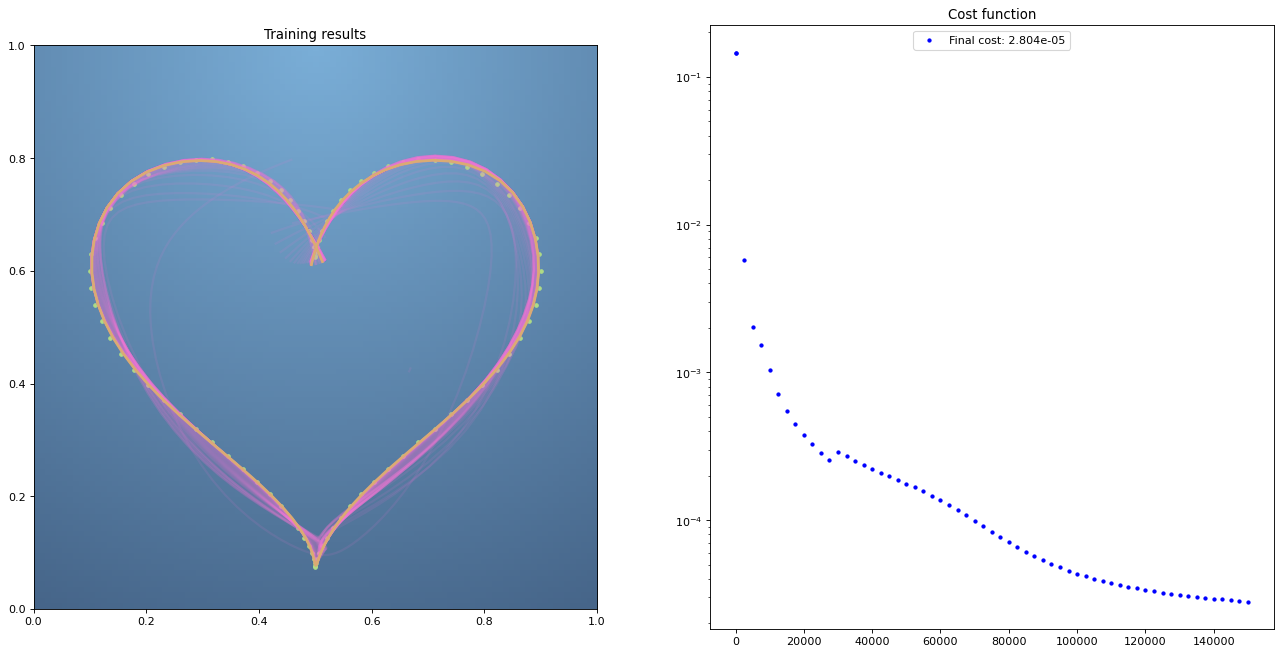

In [21]:
%time train(x, y, iterations=150000, aggression=3, reg_param=0.0)

### Four hidden layers

In [403]:
initialize_network(x, [12, 13, 13, 12, 2])

Wall time: 44.9 s


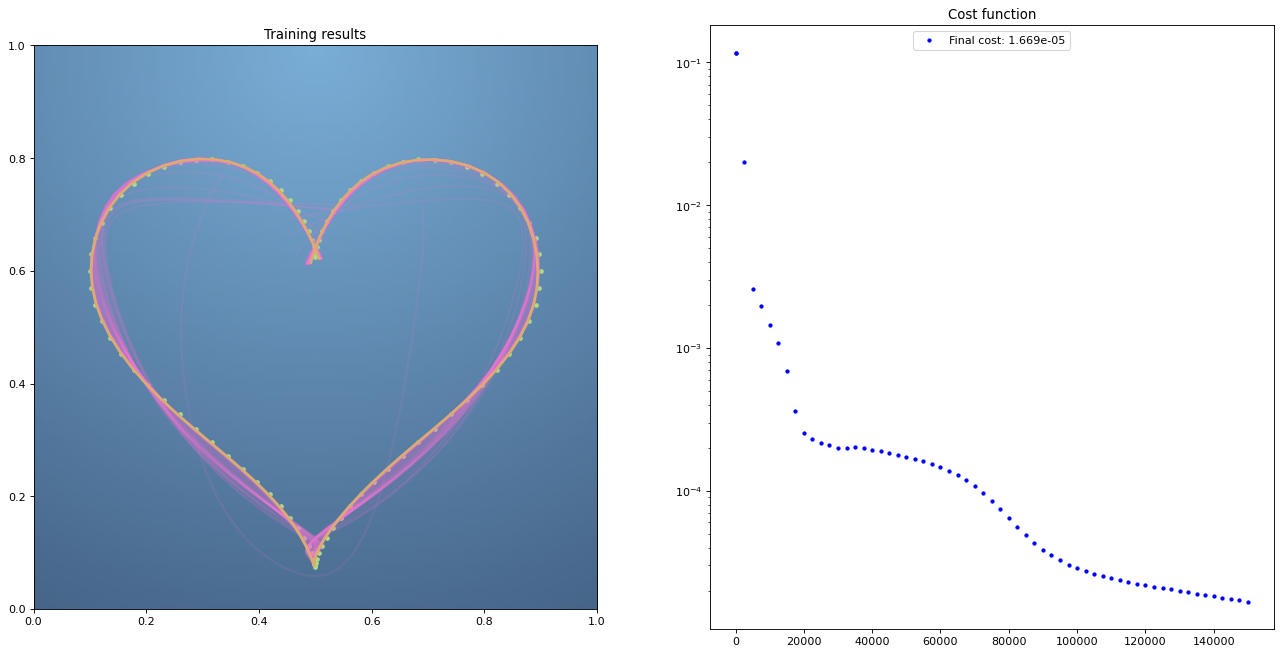

In [404]:
%time train(x, y, iterations=150000, aggression=3, reg_param=0.0)

### Five hidden layers

In [399]:
initialize_network(x, [10, 10, 10, 10, 10, 2])

Wall time: 49.9 s


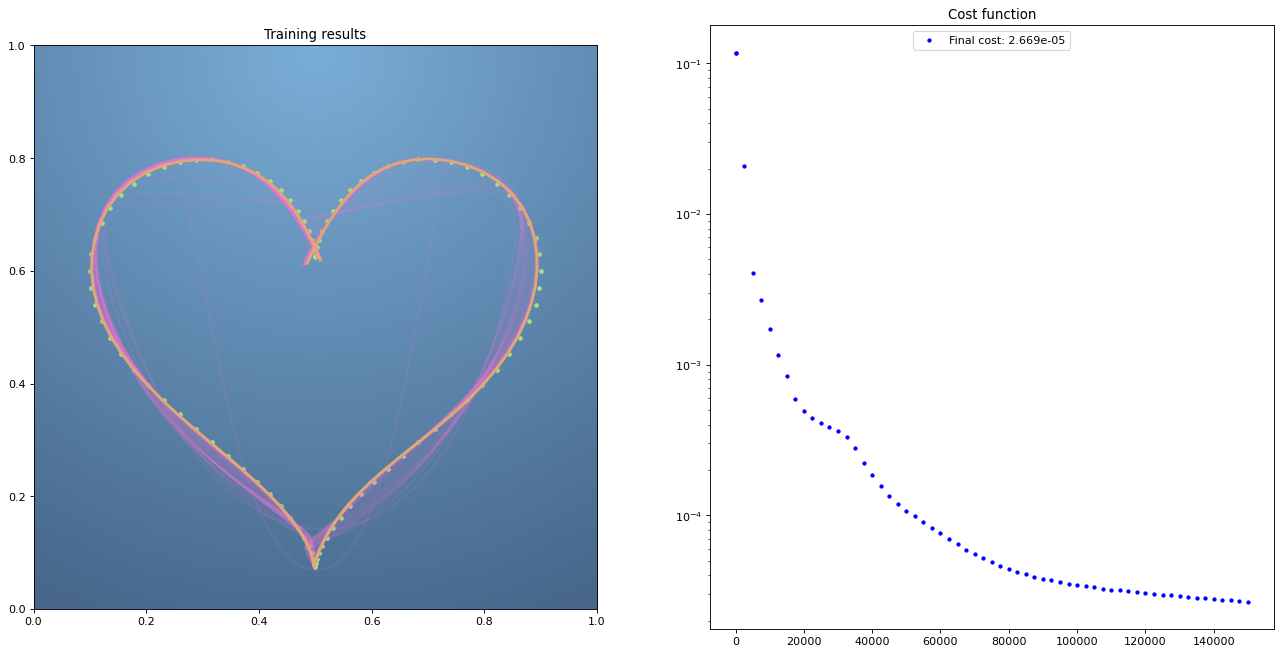

In [400]:
%time train(x, y, iterations=150000, aggression=3, reg_param=0.0)

### Six hidden layers

In [43]:
initialize_network(x, [8, 8, 9, 9, 8, 8, 2])

Wall time: 53.5 s


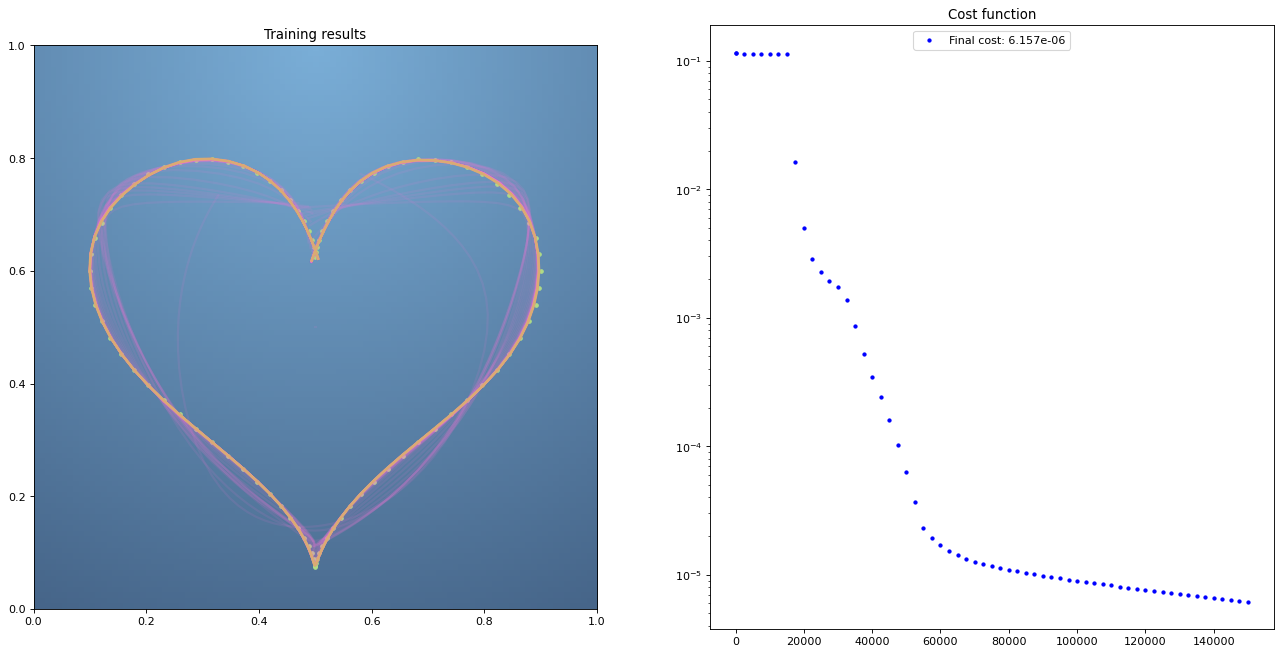

In [44]:
%time train(x, y, iterations=150000, aggression=4, reg_param=0.0)